In [1]:
import numpy as np
import math
import time
import pickle
from scipy import optimize
import polyscope as ps
from barmesh.tribarmes import trianglebarmesh
from barmesh.basicgeo import P3
import barmesh.geodesicUtils as geo

# Compare to analytical soln.

In [2]:
fname = 'geometry/Arcs/50-500-med.stl'
tbm = trianglebarmesh.TriangleBarMesh(fname)
V = tbm.GetVertices()
F = tbm.GetFaces()
n = tbm.GetNormals()

Triangle bar mesh loaded with 6606 triangles of average size 9.4


In [3]:
geopaths=[]
curvs = []
faces =[]
barF,bGoRightF,lamF,barB,bGoRightB,lamB = [],[],[],[],[],[]
select = 0
thetas = ()
maxPathLength = 1000
badFaces = []
edgeBars = tbm.GetEdgeBars()
badEdgeBars = []
geolines =[]

        
def selectBadFaces():
    global badFaces
    global select
    global edgeBars
    global badEdgeBars
    edgePts = []
    if ps.get_selection()[1] != select:
        select = ps.get_selection()[1]
        if len(V) < select < (len(V)+len(F)):
            fselect = select - len(V)
            print('face',fselect)
            badFaces.append(fselect)
            for b in tbm.faces[fselect].bars:
                for eb in edgeBars:
                    if b == eb:
                        badEdgeBars.append(eb)
                        eb.badedge = True
            eb1 = badEdgeBars[-1]
            goodEdgeBars = edgeBars
            for i in range(len(goodEdgeBars)):
                for eb2 in goodEdgeBars:
                    if (eb1.GetNodeFore(True) == eb2.GetNodeFore(True) or eb1.GetNodeFore(True) == eb2.GetNodeFore(False) or
                        eb1.GetNodeFore(False) == eb2.GetNodeFore(True) or eb1.GetNodeFore(False) == eb2.GetNodeFore(False)):
                        #print('match found at',eb2.i)
                        badEdgeBars.append(eb2)
                        eb2.badedge = True
                        goodEdgeBars.remove(eb2)
                        edgePts.append(eb2.GetNodeFore(True).p)
                        eb1 = eb2
                        break
            for b in badEdgeBars:
                if b.faceleft:
                    badFaces.append(b.faceleft)
                if b.faceright:
                    badFaces.append(b.faceright)
            col =[]
            B=(0.1,0.1,1)
            R=(1,0.1,0.1)
            badFaces = list(set(badFaces))
            for f in tbm.faces:
                bad = False
                for bf in badFaces:
                    if bf == f.i:
                        col.append(R)
                        bad = True
                if not bad:
                    col.append(B)
            #ps_surf = ps.register_surface_mesh("my mesh", V, F, smooth_shade=False)
            ps_surf.add_color_quantity("bad faces", np.array(col), defined_on='faces',enabled = True)
            if edgePts:
                ps_edgePts = ps.register_point_cloud('edgePts', geo.P3list2array(edgePts))
            
            

    else:
        return

In [4]:
#CLICK A FACE ADJENCENT TO AN EDGE TO BE AVOIDED

ps.init()

ps_surf = ps.register_surface_mesh("my mesh", V, F, edge_width = 1, smooth_shade=False)

ps.set_user_callback(selectBadFaces)
ps.show()
ps.clear_user_callback()
goodEdgeBars = geo.findGoodEdge(edgeBars,badEdgeBars)
goodEdgeBars = geo.sortBars(tbm, goodEdgeBars)

[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 3.3.0 NVIDIA 470.161.03
face 2477


In [16]:


def createSeeds(goodEdgeBars, spacing):
    spacetonext = spacing
    b = goodEdgeBars[0]
    ref0 = P3(0,1,0)
    if b.faceright:
        bFR = True
        face = b.faceright
        bFor = False
    else:
        bFR = False
        face = b.faceleft
        bFor = True
    frontPt = b.GetNodeFore(bFR).p
    backPt = b.GetNodeFore(not bFR).p
    v = backPt - frontPt
    firstSeed = frontPt + v*1e-3
    seeds = {'pts':[firstSeed],'faces':[face],'ref0s':[ref0],'thetas':[0]}

    for b in goodEdgeBars:
        bPtPlaced = False

        if b.faceright:
            bFR = True
            face = b.faceright
            bFor = False
        else:
            bFR = False
            face = b.faceleft
            bFor = True
        frontPt = b.GetNodeFore(bFR).p
        backPt = b.GetNodeFore(not bFR).p
        v = backPt - frontPt
        while v.Len() > spacetonext:
            frontPt += (v * (spacetonext/v.Len()))
            v = backPt - frontPt
            spacetonext = spacing
            seeds['pts'].append(frontPt)
            seeds['faces'].append(face)
            seeds['ref0s'].append(ref0)
            seeds['thetas'].append(0)
            bPtPlaced = True
        if bPtPlaced:
            spacetonext -= (backPt - seeds['pts'][-1]).Len()
        else:
            spacetonext -= v.Len()
    return seeds

In [7]:
# Create seed points along a line
spacing = 8
seeds = geo.createSeeds(goodEdgeBars, spacing)

In [8]:
ps.init()
ps_seedpts = ps.register_point_cloud('seedpts', geo.P3list2array(seeds['pts']))
ps_seedpts.add_vector_quantity('ref0',geo.P3list2array(seeds['ref0s']))                              
ps.show()

In [9]:

startFace = 477
x,y,z = 0,0,0
for n in tbm.faces[startFace].nodes:
    x += n.p.x/3
    y += n.p.y/3
    z += n.p.z/3
startPt = P3(x,y,z)

theta = 20
ref0 = P3(0,0,1)
geoline = geo.createGeoLine(tbm, startPt, startFace, theta, ref0, calc_thick = False, maxPathLength = 10000)
print(geoline['length'])

edge reached on path 20 deg
PATH FAIL: bad edge reached
PATH FAIL: concave area of -0.003977278888002504 on path 20
865.6752643170363


In [10]:
theta = 20
ref0 = P3(0,0,1)
geolines = []
for i in range(len(seeds['pts'])):
    startPt = seeds['pts'][i]
    startFace = seeds['faces'][i]
    geoline = geo.createGeoLine(tbm, startPt, startFace, theta, ref0, calc_thick = False, maxPathLength = 10000)
    geolines.append(geoline)

edge reached on path 20 deg
edge reached on path 20 deg
PATH FAIL: bad edge reached
PATH FAIL: concave area of -0.003472084989970221 on path 20
edge reached on path 20 deg
PATH FAIL: bad edge reached
PATH FAIL: concave area of -0.00278979400251236 on path 20
edge reached on path 20 deg
PATH FAIL: bad edge reached
PATH FAIL: concave area of -0.0029121600635960356 on path 20
edge reached on path 20 deg
PATH FAIL: bad edge reached
PATH FAIL: concave area of -0.0023340448140090585 on path 20
edge reached on path 20 deg
PATH FAIL: bad edge reached
PATH FAIL: concave area of -0.0024992379228054745 on path 20
edge reached on path 20 deg
edge reached on path 20 deg
PATH FAIL: bad edge reached
PATH FAIL: concave area of -0.00511742604321353 on path 20
edge reached on path 20 deg
PATH FAIL: bad edge reached
PATH FAIL: concave area of -0.005759059442563693 on path 20
edge reached on path 20 deg
PATH FAIL: bad edge reached
PATH FAIL: concave area of -0.004469830894259531 on path 20
edge reached on

In [52]:
ds = []
for i in range(1,len(geoline['pts'])):
    ds.append(P3.Len(geoline['pts'][i]-geoline['pts'][i-1]))
meshsize=0
for b in tbm.bars:
    meshsize += P3.Len(b.GetNodeFore(True).p-b.GetNodeFore(False).p)/len(tbm.bars)
meshsize
curvs = [0]
for i in range(1,len(geoline['pts'])-1):
    vlast = geoline['pts'][i] - geoline['pts'][i-1]
    vnext = geoline['pts'][i+1] - geoline['pts'][i]
    curvature = P3.Dot(P3.ZNorm(tbm.faces[geoline['faces'][i]].normal),P3.ZNorm(vlast))    
    curvs.append(curvature)
curvs.append(0)


smcurvs = []
av = 100
for i in range(len(geoline['pts'])):
    lo = max(0,i-av)
    hi = min(i+av+1,len(geoline['pts']))
    #print(i,lo,hi)
    sm = 0
    for j in range(lo,hi):
        d = 1+(sum(ds[j:i])+sum(ds[i:j]))/meshsize
        c = curvs[j]
        #print('d:',d,'c',c)
        sm += (c/d**2)
    smcurvs.append(sm)

In [11]:
ps.init()
colours = []
for s in geoline['curvs']:
    if s >0:
        colours.append((0,1,0.5))
    else:
        colours.append((1,0,0))
ps_surf = ps.register_surface_mesh("my mesh", V, F, smooth_shade=False)
ps_geoline = ps.register_curve_network('geoline', geo.P3list2array(geoline['pts']), 'line')
ps_geolinepts = ps.register_point_cloud('geolinepts', geo.P3list2array(geoline['pts']))
ps_geoline.add_scalar_quantity("curvature", np.array(geoline['curvs']), defined_on='nodes', enabled=True,  cmap='coolwarm')#,vminmax=(-1e-2, 1e-2))
ps_geoline.add_color_quantity("windable", np.array(colours), defined_on='nodes', enabled=True)
#ps_geolinepts.add_scalar_quantity("curvature", np.array(smcurvs), enabled=True,  cmap='coolwarm')#,vminmax=(-1e-2, 1e-2))
ps_seedpts = ps.register_point_cloud('seedpts', geo.P3list2array([startPt]))
ps_seedpts.add_vector_quantity('ref0',geo.P3list2array([ref0]))                              
#rps_geolinepts = ps.register_point_cloud('rgeolinepts', geo.P3list2array(geolinerev['pts']))
#rps_geolinepts.add_scalar_quantity("curvature", np.array(rcurvs), enabled=True,  cmap='coolwarm')
ps.show()

In [13]:
geonodes = []

for geoline in geolines:
    geonodes = geonodes + geoline['pts']
ps.init()
ps_surf = ps.register_surface_mesh("my mesh", V, F, smooth_shade=False)
ps_geolines = ps.register_curve_network('geolines', geo.P3list2array(geonodes), 'line')
ps.show()

In [55]:
cdist = [0]
for d in ds:
    cdist.append(cdist[-1]+d)


In [ ]:
with open('geometry/Arcs/50-200curvs-coarse.pkl', 'wb') as file_out:
    pickle.dump((cdist,smcurvs),file_out,-1)

In [20]:
with open('geometry/Arcs/50-200curvs-fine.pkl', 'rb') as input:
    fine=pickle.load(input)
    
with open('geometry/Arcs/50-200curvs-coarse.pkl', 'rb') as input:
    coarse=pickle.load(input)
    
with open('geometry/Arcs/50-200curvs-med.pkl', 'rb') as input:
    med=pickle.load(input)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


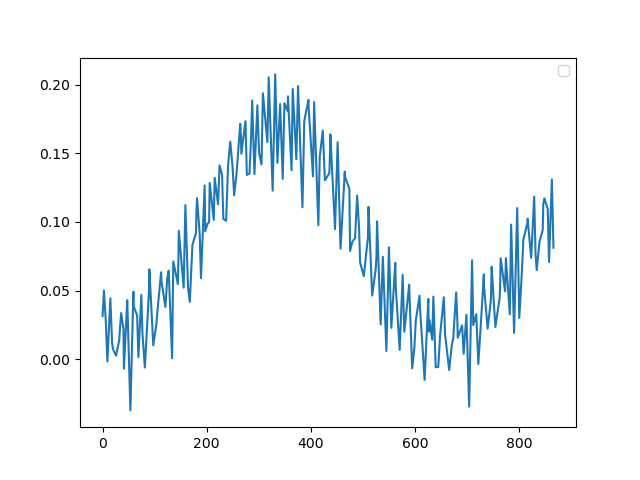

In [56]:
from matplotlib import pyplot as plt
%matplotlib widget

fig = plt.figure()
plt.plot(cdist,smcurvs)
#plt.plot(fine[0],fine[1], label = 'Fine mesh')
#plt.plot(med[0],med[1], label = 'Medium mesh')
#plt.plot(coarse[0],coarse[1], label = 'Coarse mesh')
plt.legend()
plt.show()